In [227]:
import yfinance as yf
import pandas as pd

# Define the stock symbols and time period
aapl_symbol = "AAPL"
market_symbol = "^GSPC"  # S&P 500 index
start_date = "2008-01-01"
end_date = "2022-12-31"

# Retrieve the stock data
aapl_data = yf.download(aapl_symbol, start=start_date, end=end_date)
market_data = yf.download(market_symbol, start=start_date, end=end_date)

# Calculate the daily returns
aapl_data["Returns"] = aapl_data["Close"].pct_change()
market_data["Returns"] = market_data["Close"].pct_change()

# Merge the data and keep only the adjusted close column
merged_data = pd.merge(aapl_data["Adj Close"], market_data["Adj Close"], on="Date", suffixes=("_AAPL", "_Market"))
merged_data = merged_data.dropna()
merged_data


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Adj Close_AAPL  Adj Close_Market
Date                                        
2008-01-02        5.898639       1447.160034
2008-01-03        5.901364       1447.160034
2008-01-04        5.450884       1411.630005
2008-01-07        5.377924       1416.180054
2008-01-08        5.184469       1390.189941
...                    ...               ...
2022-12-23      131.127060       3844.820068
2022-12-27      129.307236       3829.250000
2022-12-28      125.339409       3783.219971
2022-12-29      128.889572       3849.280029
2022-12-30      129.207779       3839.500000

[3777 rows x 2 columns]

In [228]:
merged_data = merged_data.rename(columns={"Adj Close_AAPL": "AAPL", "Adj Close_Market": "Market"})
merged_data


AAPL       Market
Date                               
2008-01-02    5.898639  1447.160034
2008-01-03    5.901364  1447.160034
2008-01-04    5.450884  1411.630005
2008-01-07    5.377924  1416.180054
2008-01-08    5.184469  1390.189941
...                ...          ...
2022-12-23  131.127060  3844.820068
2022-12-27  129.307236  3829.250000
2022-12-28  125.339409  3783.219971
2022-12-29  128.889572  3849.280029
2022-12-30  129.207779  3839.500000

[3777 rows x 2 columns]

In [229]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from fracdiff2 import frac_diff_ffd

def plot_multi(data, cols=None, spacing=.1, **kwargs):
    # Get default color style from pandas - can be changed to any other color list
    if cols is None:
        cols = data.columns
    if len(cols) == 0:
        return
    colors = ['r', 'b', 'g']

    # First axis
    ax = data[cols[0]].plot(label=cols[0], color=colors[0], **kwargs)
    ax.set_ylabel(ylabel=cols[0])
    lines, labels = ax.get_legend_handles_labels()

    for n in range(1, len(cols)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
        data[cols[n]].plot(ax=ax_new, label=cols[n], color=colors[n % len(colors)])
        ax_new.set_ylabel(ylabel=cols[n])

        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label

    ax.legend(lines, labels, loc=0)
    return ax


fractional_returns = frac_diff_ffd(merged_data['AAPL'].apply(np.log).values, d=0.5)
merged_data['Frac_Diff_AAPL'] = fractional_returns
merged_data['No_Diff_AAPL'] = merged_data['AAPL']
AAPL_df = merged_data[['No_Diff_AAPL', 'Frac_Diff_AAPL']]


fractional_returns = frac_diff_ffd(merged_data['Market'].apply(np.log).values, d=0.5)
merged_data['Frac_Diff_Market'] = fractional_returns
merged_data['No_Diff_Market'] = merged_data['Market']
Market_df = merged_data[['No_Diff_Market', 'Frac_Diff_Market']]


# Assuming 'column_name' is the name of your column
first_non_zero_index = AAPL_df['Frac_Diff_AAPL'].ne(0).idxmax()
AAPL_df = AAPL_df.loc[first_non_zero_index:]

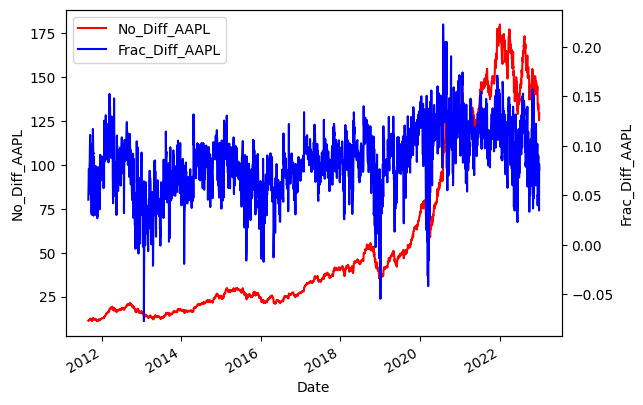

In [230]:
plot_multi(AAPL_df)
plt.show()


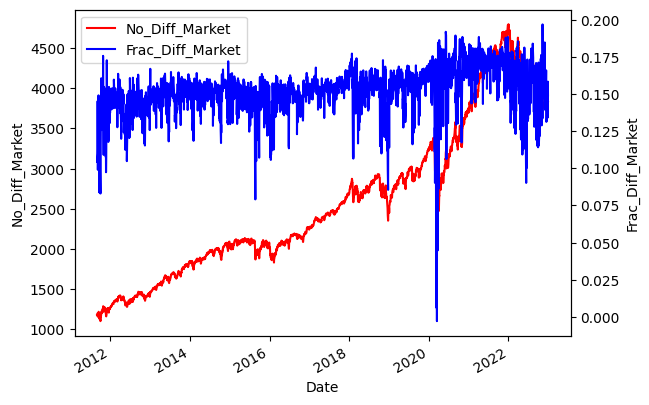

In [231]:


first_non_zero_index = Market_df['Frac_Diff_Market'].ne(0).idxmax()
Market_df = Market_df.loc[first_non_zero_index:]
plot_multi(Market_df)
plt.show()

In [232]:


merged_fracdiff = pd.merge(AAPL_df[['Frac_Diff_AAPL']],Market_df[['Frac_Diff_Market']], on='Date')
merged_fracdiff



Frac_Diff_AAPL  Frac_Diff_Market
Date                                        
2011-09-02        0.045528          0.104338
2011-09-06        0.070739          0.110038
2011-09-07        0.076664          0.145203
2011-09-08        0.070961          0.122875
2011-09-09        0.051486          0.099008
...                    ...               ...
2022-12-23        0.065870          0.149389
2022-12-27        0.056532          0.144059
2022-12-28        0.034641          0.134184
2022-12-29        0.081485          0.158322
2022-12-30        0.075976          0.149145

[2851 rows x 2 columns]

In [233]:
import statsmodels.api as sm
merged_data=merged_fracdiff
# Define the independent variable (X) and dependent variable (y)
X = merged_data.iloc[:, 1]  # Second column
y = merged_data.iloc[:, 0]  # First column

# Add a constant term to the independent variable
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X)
results = model.fit()

coefficients = results.params
coefficients


const              -0.122866
Frac_Diff_Market    1.366880
dtype: float64

In [234]:

merged_data["Alpha"] = 0
merged_data["beta"] = 0
merged_data["R_squared"] = 0
merged_data["p_value_alpha"] = 0
merged_data["p_value_market"] = 0

merged_data


Frac_Diff_AAPL  Frac_Diff_Market  Alpha  beta  R_squared  \
Date                                                                   
2011-09-02        0.045528          0.104338      0     0          0   
2011-09-06        0.070739          0.110038      0     0          0   
2011-09-07        0.076664          0.145203      0     0          0   
2011-09-08        0.070961          0.122875      0     0          0   
2011-09-09        0.051486          0.099008      0     0          0   
...                    ...               ...    ...   ...        ...   
2022-12-23        0.065870          0.149389      0     0          0   
2022-12-27        0.056532          0.144059      0     0          0   
2022-12-28        0.034641          0.134184      0     0          0   
2022-12-29        0.081485          0.158322      0     0          0   
2022-12-30        0.075976          0.149145      0     0          0   

            p_value_alpha  p_value_market  
Date                                       
2011-09-02              0               0  
2011-09-06              0               0  
2011-09-07              0               0  
2011-09-08              0               0  
2011-09-09              0               0  
...                   ...             ...  
2022-12-23              0               0  
2022-12-27              0               0  
2022-12-28              0               0  
2022-12-29              0               0  
2022-12-30              0               0  

[2851 rows x 7 columns]

In [235]:
for x in range(0, len(merged_data)-3):
    # Define the independent variable (X) and dependent variable (y)
    X = merged_data.iloc[:x+2, 1]  # Second column, first 2 rows
    y = merged_data.iloc[:x+2, 0]  # First column, first 2 rows

    # Add a constant term to the independent variable
    X = sm.add_constant(X)

    # Fit the linear regression model
    model = sm.OLS(y, X)
    results = model.fit()

    # Get the beta coefficient
    beta = results.params[1]
    r_squared = results.rsquared
    intercept = results.params[0]
    p_value_alpha = results.pvalues[0]
    p_value_market = results.pvalues[1]

    # Find the column index of 'beta'
    beta_index = merged_data.columns.get_loc('beta')
    r_squared_index = merged_data.columns.get_loc('R_squared')
    intercept_index = merged_data.columns.get_loc('Alpha')
    p_value_alpha_index = merged_data.columns.get_loc('p_value_alpha')
    p_value_market_index = merged_data.columns.get_loc('p_value_market')

    # Use iloc to set the value
    merged_data.iloc[x+1+2, beta_index] = beta
    merged_data.iloc[x+1+2, r_squared_index] = r_squared
    merged_data.iloc[x+1+2, intercept_index] = intercept
    merged_data.iloc[x+1+2, p_value_alpha_index] = p_value_alpha
    merged_data.iloc[x+1+2, p_value_market_index] = p_value_market


    



/var/folders/0f/pslgclyj7tx7mwrxw99wp0t40000gn/T/ipykernel_6469/3804733453.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = results.params[1]
/var/folders/0f/pslgclyj7tx7mwrxw99wp0t40000gn/T/ipykernel_6469/3804733453.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = results.params[0]
/var/folders/0f/pslgclyj7tx7mwrxw99wp0t40000gn/T/ipykernel_6469/3804733453.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

In [236]:



merged_data

Frac_Diff_AAPL  Frac_Diff_Market     Alpha      beta  R_squared  \
Date                                                                          
2011-09-02        0.045528          0.104338  0.000000  0.000000   0.000000   
2011-09-06        0.070739          0.110038  0.000000  0.000000   0.000000   
2011-09-07        0.076664          0.145203  0.000000  0.000000   0.000000   
2011-09-08        0.070961          0.122875 -0.415952  4.422952   1.000000   
2011-09-09        0.051486          0.099008 -0.001936  0.552697   0.547403   
...                    ...               ...       ...       ...        ...   
2022-12-23        0.065870          0.149389 -0.122695  1.365940   0.446912   
2022-12-27        0.056532          0.144059 -0.122720  1.366090   0.447033   
2022-12-28        0.034641          0.134184 -0.122733  1.366140   0.447016   
2022-12-29        0.081485          0.158322 -0.122768  1.366330   0.447058   
2022-12-30        0.075976          0.149145 -0.122876  1.366979   0.447297   

            p_value_alpha  p_value_market  
Date                                       
2011-09-02   0.000000e+00        0.000000  
2011-09-06   0.000000e+00        0.000000  
2011-09-07   0.000000e+00        0.000000  
2011-09-08            NaN             NaN  
2011-09-09   9.797798e-01        0.469777  
...                   ...             ...  
2022-12-23  6.124992e-155        0.000000  
2022-12-27  4.279734e-155        0.000000  
2022-12-28  3.685357e-155        0.000000  
2022-12-29  2.786429e-155        0.000000  
2022-12-30  1.380799e-155        0.000000  

[2851 rows x 7 columns]

In [237]:
merged_data["Expected_Return"] = merged_data["beta"]+ merged_data["Alpha"]
merged_data


Frac_Diff_AAPL  Frac_Diff_Market     Alpha      beta  R_squared  \
Date                                                                          
2011-09-02        0.045528          0.104338  0.000000  0.000000   0.000000   
2011-09-06        0.070739          0.110038  0.000000  0.000000   0.000000   
2011-09-07        0.076664          0.145203  0.000000  0.000000   0.000000   
2011-09-08        0.070961          0.122875 -0.415952  4.422952   1.000000   
2011-09-09        0.051486          0.099008 -0.001936  0.552697   0.547403   
...                    ...               ...       ...       ...        ...   
2022-12-23        0.065870          0.149389 -0.122695  1.365940   0.446912   
2022-12-27        0.056532          0.144059 -0.122720  1.366090   0.447033   
2022-12-28        0.034641          0.134184 -0.122733  1.366140   0.447016   
2022-12-29        0.081485          0.158322 -0.122768  1.366330   0.447058   
2022-12-30        0.075976          0.149145 -0.122876  1.366979   0.447297   

            p_value_alpha  p_value_market  Expected_Return  
Date                                                        
2011-09-02   0.000000e+00        0.000000         0.000000  
2011-09-06   0.000000e+00        0.000000         0.000000  
2011-09-07   0.000000e+00        0.000000         0.000000  
2011-09-08            NaN             NaN         4.007000  
2011-09-09   9.797798e-01        0.469777         0.550762  
...                   ...             ...              ...  
2022-12-23  6.124992e-155        0.000000         1.243245  
2022-12-27  4.279734e-155        0.000000         1.243370  
2022-12-28  3.685357e-155        0.000000         1.243407  
2022-12-29  2.786429e-155        0.000000         1.243562  
2022-12-30  1.380799e-155        0.000000         1.244104  

[2851 rows x 8 columns]

In [238]:
merged_data["Tracking_Error"] = merged_data["Expected_Return"] - merged_data["Frac_Diff_AAPL"]
merged_data



Frac_Diff_AAPL  Frac_Diff_Market     Alpha      beta  R_squared  \
Date                                                                          
2011-09-02        0.045528          0.104338  0.000000  0.000000   0.000000   
2011-09-06        0.070739          0.110038  0.000000  0.000000   0.000000   
2011-09-07        0.076664          0.145203  0.000000  0.000000   0.000000   
2011-09-08        0.070961          0.122875 -0.415952  4.422952   1.000000   
2011-09-09        0.051486          0.099008 -0.001936  0.552697   0.547403   
...                    ...               ...       ...       ...        ...   
2022-12-23        0.065870          0.149389 -0.122695  1.365940   0.446912   
2022-12-27        0.056532          0.144059 -0.122720  1.366090   0.447033   
2022-12-28        0.034641          0.134184 -0.122733  1.366140   0.447016   
2022-12-29        0.081485          0.158322 -0.122768  1.366330   0.447058   
2022-12-30        0.075976          0.149145 -0.122876  1.366979   0.447297   

            p_value_alpha  p_value_market  Expected_Return  Tracking_Error  
Date                                                                        
2011-09-02   0.000000e+00        0.000000         0.000000       -0.045528  
2011-09-06   0.000000e+00        0.000000         0.000000       -0.070739  
2011-09-07   0.000000e+00        0.000000         0.000000       -0.076664  
2011-09-08            NaN             NaN         4.007000        3.936039  
2011-09-09   9.797798e-01        0.469777         0.550762        0.499276  
...                   ...             ...              ...             ...  
2022-12-23  6.124992e-155        0.000000         1.243245        1.177375  
2022-12-27  4.279734e-155        0.000000         1.243370        1.186838  
2022-12-28  3.685357e-155        0.000000         1.243407        1.208766  
2022-12-29  2.786429e-155        0.000000         1.243562        1.162077  
2022-12-30  1.380799e-155        0.000000         1.244104        1.168127  

[2851 rows x 9 columns]